# Supervised Learning of Drug Response using CORES from Copy Number Log Ratio

### Import Python source code

In [83]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 26 12:21:38 2018

@author: bbece
"""

from __future__ import division, print_function, unicode_literals
import numpy as np
import os
from IPython.display import display, HTML

from pprint import pprint
np.random.seed(42)

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
            
import pandas as pd
import scipy

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler

from sklearn import decomposition

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.tree import export_graphviz

import math



### Load training set matrix

In [193]:
#labeled_matrix_training_set = pd.read_csv("../mlOutput/geneTrainingSet_8_5_2018_1.csv") # Cancer gene feature set
#labeled_matrix_training_set = pd.read_csv("../mlOutput/slicingTrainingSet_8_3_2018_1.csv") # Slicing features on A and D combined
labeled_matrix_training_set = pd.read_csv("../mlOutput/coreTrainingSet_8_2_2018_2.csv") # Segment features on A and D combined
#labeled_matrix_training_set = pd.read_csv("../mlOutput/coreTrainingSet_8_2_2018_1.csv") # Segment features on A and D merged
#labeled_matrix_training_set.columns.values[0] = "sampleId"
labeled_matrix_training_set = labeled_matrix_training_set.drop([labeled_matrix_training_set.columns[0]], axis = 1)
labels = list(range(0,5))


In [194]:
display(labeled_matrix_training_set.head(25))

,Gemcitabine,Paclitaxel,SN-38,5-FU,Oxaliplatin,1,3,8,9,16,...,65,67,68,69,70,72,73,74,77,80
0,0.576312,0.715357,0.542345,0.770327,0.875863,0.436093,0.219046,0.093381,0.306327,-0.850429,...,0.091356,-0.020526,0.305247,-0.097172,0.091364,-0.936458,-0.861014,-0.953599,0.979149,-0.069036
1,0.531357,0.481223,0.552329,0.778592,0.802963,0.522301,0.332260,0.036914,0.233745,-0.951033,...,0.037372,-0.353375,-0.111128,-0.611878,-0.351904,-0.289993,-0.324749,-0.375740,-0.263046,-0.427196
2,0.610292,0.748410,0.544124,0.673957,0.790218,0.395108,-0.059497,-0.056061,0.109607,-1.585542,...,-0.121145,-0.175617,-0.052702,-0.425628,0.049563,-0.543270,-0.536459,-0.642908,0.251044,0.088374
3,0.677571,0.647227,0.562632,0.826889,0.835748,0.132817,0.529099,-0.040379,0.202314,-0.619159,...,0.414758,0.183085,0.685537,0.189467,0.549099,-0.637489,-0.642251,-0.772321,0.572187,-1.629346
4,0.694529,0.653745,0.651769,0.850960,0.813800,0.207992,0.265925,0.114829,0.234293,-0.879316,...,0.136851,0.510556,0.287325,0.589296,0.824069,0.011819,-0.754368,-0.047061,0.572734,-1.053957
5,0.625919,0.546421,0.570326,0.723314,0.943585,0.099434,0.458407,0.783488,0.953391,-0.255512,...,-0.189842,-0.323942,-0.132488,-0.580421,-0.107210,-0.253809,-0.300951,-0.355237,1.404891,0.196116
6,0.619415,0.566868,0.548342,0.755120,0.841761,-0.960577,0.375832,-0.173501,0.123302,-0.562097,...,0.025176,-0.390782,-1.956893,-1.476872,-1.255124,0.184695,0.159322,0.046950,-0.203930,-0.807023
7,0.557171,0.577914,0.611604,0.895087,0.914860,-0.334538,0.416808,0.317006,0.459243,-1.689432,...,0.371994,-0.222975,0.139134,-0.357164,-0.004910,-0.180432,-0.212158,-0.218690,0.410748,-1.764445
8,0.821077,0.698895,0.790806,NaN,NaN,-0.557269,0.301038,0.195996,0.364016,-0.690727,...,0.273373,0.029492,0.520527,-0.305875,0.234380,0.191366,0.088789,0.084635,-0.158168,-0.735119
9,NaN,NaN,NaN,NaN,NaN,0.472155,-0.079524,0.286920,0.462819,-0.417980,...,-0.244722,-0.314863,-0.243135,-0.440525,-0.080551,-0.213000,-0.366078,0.475861,0.663687,-0.376184


In [195]:
X = labeled_matrix_training_set.copy().drop(labeled_matrix_training_set.columns[labels], axis = 1)
y = labeled_matrix_training_set.copy()[labeled_matrix_training_set.columns[labels]]

In [196]:
display(X.head())

,1,3,8,9,16,18,22,23,24,30,...,65,67,68,69,70,72,73,74,77,80
0,0.436093,0.219046,0.093381,0.306327,-0.850429,0.054373,0.611854,0.114151,0.196272,0.313453,...,0.091356,-0.020526,0.305247,-0.097172,0.091364,-0.936458,-0.861014,-0.953599,0.979149,-0.069036
1,0.522301,0.332260,0.036914,0.233745,-0.951033,-0.695467,-0.022730,0.508777,-0.047856,-0.052709,...,0.037372,-0.353375,-0.111128,-0.611878,-0.351904,-0.289993,-0.324749,-0.375740,-0.263046,-0.427196
2,0.395108,-0.059497,-0.056061,0.109607,-1.585542,0.027163,-0.101243,-0.467931,0.036215,0.576793,...,-0.121145,-0.175617,-0.052702,-0.425628,0.049563,-0.543270,-0.536459,-0.642908,0.251044,0.088374
3,0.132817,0.529099,-0.040379,0.202314,-0.619159,0.196007,-0.189890,0.029501,0.583344,0.240416,...,0.414758,0.183085,0.685537,0.189467,0.549099,-0.637489,-0.642251,-0.772321,0.572187,-1.629346
4,0.207992,0.265925,0.114829,0.234293,-0.879316,0.020543,0.028597,0.103498,0.247794,-0.674535,...,0.136851,0.510556,0.287325,0.589296,0.824069,0.011819,-0.754368,-0.047061,0.572734,-1.053957


In [197]:
display(y.head(15))

,Gemcitabine,Paclitaxel,SN-38,5-FU,Oxaliplatin
0,0.576312,0.715357,0.542345,0.770327,0.875863
1,0.531357,0.481223,0.552329,0.778592,0.802963
2,0.610292,0.748410,0.544124,0.673957,0.790218
3,0.677571,0.647227,0.562632,0.826889,0.835748
4,0.694529,0.653745,0.651769,0.850960,0.813800
5,0.625919,0.546421,0.570326,0.723314,0.943585
6,0.619415,0.566868,0.548342,0.755120,0.841761
7,0.557171,0.577914,0.611604,0.895087,0.914860
8,0.821077,0.698895,0.790806,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN


In [198]:
from sklearn.model_selection import train_test_split

all_X_TRAIN, all_X_TEST, all_Y_TRAIN, all_Y_TEST = train_test_split(X, y, test_size=0.20, random_state=42)
# TODO: train_test must be split on amount of NAs as well!

In [199]:
display(all_X_TRAIN.head())
display(all_Y_TRAIN.head())

,1,3,8,9,16,18,22,23,24,30,...,65,67,68,69,70,72,73,74,77,80
77,0.258306,0.145592,0.073569,0.233113,-0.872274,-0.003441,-0.876731,0.070761,0.209528,0.186785,...,0.088916,-0.010087,0.112097,-0.390746,0.209502,-0.472049,-0.530861,-0.583882,0.011045,-0.110352
42,0.015101,0.101111,0.454659,0.622593,-0.475914,-0.154996,0.299835,0.445097,-0.271932,0.606860,...,0.136426,-0.073334,-1.168295,-0.064467,-0.051636,-0.531497,-0.575316,0.329361,0.382632,-0.776200
49,0.217305,0.165285,0.038625,0.236605,0.024422,-0.022316,-0.041843,0.095888,0.266678,0.251558,...,0.089018,-0.079240,0.197433,-0.045743,-0.000390,-0.026707,-0.038772,-0.088335,0.059579,-0.158037
11,0.364066,0.187369,0.040675,0.197984,0.107907,-0.060339,-0.000354,0.098138,0.251695,0.306306,...,0.098393,-0.037589,0.170131,-0.142253,-0.009636,0.018646,-0.016037,-0.105612,0.039937,-0.090132
30,-0.109660,-0.007023,-0.205337,0.104510,-0.689720,0.251075,0.050076,0.281951,0.103067,0.713898,...,0.537130,-0.229109,-1.315222,-0.590476,-0.181312,-0.203817,-0.208228,-0.255898,0.576892,-0.807384


,Gemcitabine,Paclitaxel,SN-38,5-FU,Oxaliplatin
77,NaN,NaN,NaN,NaN,NaN
42,0.645679,0.630910,0.682710,0.942370,0.839335
49,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN
30,0.637520,0.652945,0.679371,0.822522,0.927028


In [200]:
display(all_X_TEST.head())
display(all_Y_TEST.head())

,1,3,8,9,16,18,22,23,24,30,...,65,67,68,69,70,72,73,74,77,80
78,0.292643,0.353997,0.326176,0.010531,-0.415178,-0.586578,0.255556,0.350862,0.349508,0.208518,...,-0.255366,0.105168,-0.101392,-0.038439,0.178200,-0.676184,-0.689558,-0.737489,0.188873,-0.776995
0,0.436093,0.219046,0.093381,0.306327,-0.850429,0.054373,0.611854,0.114151,0.196272,0.313453,...,0.091356,-0.020526,0.305247,-0.097172,0.091364,-0.936458,-0.861014,-0.953599,0.979149,-0.069036
68,0.268986,0.176367,0.051902,0.221065,0.050702,-0.019201,-0.085611,0.115679,0.299410,0.203980,...,0.059569,-0.029386,0.247056,0.015869,0.284147,0.036860,-0.002521,-0.109247,0.051980,-0.073419
22,1.386500,-0.426669,-0.052686,0.114342,0.388810,0.212170,-0.137946,-0.010398,0.834895,-0.396658,...,-0.015449,-0.441255,0.820187,0.256869,0.381185,-0.129726,-0.700858,-0.175675,-0.024058,-0.780400
12,0.274256,0.199654,0.056263,0.238684,0.015601,-0.004171,-0.055126,0.097506,0.261574,0.229485,...,0.092569,-0.022773,0.328441,0.031708,0.213800,0.027782,-0.000234,-0.079043,0.046129,-0.109735


,Gemcitabine,Paclitaxel,SN-38,5-FU,Oxaliplatin
78,0.777284,0.745540,0.701093,0.924357,0.866260
0,0.576312,0.715357,0.542345,0.770327,0.875863
68,NaN,NaN,NaN,NaN,NaN
22,0.915466,0.756732,0.877780,0.963176,1.000000
12,NaN,NaN,NaN,NaN,NaN


## Visualize ML Results

In [201]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

In [202]:
def retrieve_pipelines(model_name, ml_model, scaling_method = "standard"):
    
    labelScaler = StandardScaler() if scaling_method == "standard" else MinMaxScaler()
    featureScaler = StandardScaler() if scaling_method == "standard" else MinMaxScaler()
    
    labelPipeline = Pipeline([
     ('imputer', Imputer(axis=0,strategy="median")),
     ('scaler', labelScaler),
    ])
    
    modelPipeline = Pipeline([
            #('imputer', Imputer(axis=0,strategy="median")),
            #('scaler', StandardScaler()),
            #('scaler', MinMaxScaler()),
            #("pca", decomposition.PCA(n_components=10)),
            (model_name,  ml_model)
    ])
    
    featureSetPipeline = Pipeline([
        ('imputer', Imputer(axis=0,strategy="median")),
        ('scaler', featureScaler),
    ])
    
    return (modelPipeline, labelPipeline, featureSetPipeline)

def imputer_inverse_transform(pre_data, post_data):
    na_indices = np.where(np.isnan(pre_data))[0]
    post_data[na_indices] = float('NaN')
    return post_data
    
def remove_NAs(X, y, label):
    label_y = y[[y.columns[label]]]
    na_indices = label_y[label_y.columns[0]].index[label_y[label_y.columns[0]].apply(np.isnan)]
    y_nonNA = label_y.copy().drop(na_indices)
    X_nonNA = X.copy().drop(na_indices)
    return X_nonNA, y_nonNA
    
def train_and_test(labelPipeline, XYpipeline, X_TRAIN, X_TEST, this_y_train, this_y_test):
    XYpipeline.fit(X_TRAIN,this_y_train)

    y_prediction = XYpipeline.predict(X_TEST)
    
    y_prediction = labelPipeline.named_steps['scaler'].inverse_transform(y_prediction)
    y_prediction = imputer_inverse_transform(this_y_test, y_prediction)

    y_test_np = labelPipeline.named_steps['scaler'].inverse_transform(this_y_test)
    y_test_np = y_test_np[~np.isnan(y_test_np)]
    y_prediction = y_prediction[~np.isnan(y_prediction)]
    return (y_test_np, y_prediction, this_y_train_tr)


def simple_score(y_test_np, y_prediction):
    rmse = np.sqrt(mean_squared_error(y_test_np, y_prediction))
    r = scipy.stats.pearsonr(y_test_np, y_prediction)
    t = scipy.stats.spearmanr(y_test_np, y_prediction)
    return (rmse, r, t)
    
def visualize(y_test_np, y_prediction):
    plt.plot(y_test_np, y_prediction, 'bo')
    abline(1,0)
    plt.ylabel("Prediction")
    plt.xlabel("Label")
    plt.show()
    
def display_set(X_TRAIN, X_TEST, Y_TRAIN, Y_TEST):
    TRAIN = pd.concat([Y_TRAIN, X_TRAIN], axis=1)
    TEST = pd.concat([Y_TEST, X_TEST], axis=1)
    pprint("TRAIN")
    display(TRAIN)
    pprint("TEST")
    display(TEST)

def cv_score(XYpipeline, X_TRAIN, this_y_train_tr):
    scores = cross_val_score(XYpipeline, X_TRAIN, this_y_train_tr,
                             scoring = "neg_mean_squared_error", cv=10)
    scores = Ypipeline.named_steps['normalizer'].inverse_transform(scores)
    return scores


### Visualize ML results using Ridge Regression

'TRAIN'


,Gemcitabine,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
55,0.193720,0.156556,1.000000,0.008697,0.578871,0.459694,0.509715,0.785397,0.954744,0.487228,...,0.559633,0.583954,0.650810,0.567892,0.693794,0.865636,0.842965,0.627083,0.422313,0.265169
14,0.239964,0.538768,0.450830,0.000000,0.000000,0.899807,0.369437,0.447762,0.484931,0.496228,...,0.553908,0.579830,0.799303,0.746681,0.617332,0.893803,0.810621,0.635395,0.364281,0.583968
50,0.173108,0.315570,0.493621,0.282766,0.652270,0.484098,0.455033,0.370979,0.370050,0.604219,...,0.461069,0.487476,0.717166,0.453187,0.650282,1.000000,1.000000,0.804717,0.564712,0.037158
17,0.256885,0.175859,0.436437,0.643136,0.636647,0.492062,0.696678,0.544771,0.444176,0.565450,...,0.629643,0.706401,0.745023,0.611213,0.653760,0.654363,0.570014,0.469477,0.310533,0.606470
24,0.260888,0.666774,0.532750,0.501681,0.447857,0.758085,0.265007,0.897965,0.707626,0.635461,...,0.532536,0.092981,0.394541,0.096092,0.207210,0.752345,0.702895,0.126178,0.639310,1.000000
33,0.388252,0.642013,0.433032,0.649818,0.272455,0.528888,0.400068,0.725435,0.854246,0.358252,...,0.238406,0.614824,0.758995,0.736739,0.695500,0.852728,0.809026,0.651647,0.478803,0.614304
80,0.432439,0.505809,0.406499,0.596593,0.593182,0.402880,0.381676,1.000000,0.518664,0.743133,...,0.577359,0.591060,0.819576,0.613182,0.678784,0.373595,0.101834,0.653827,0.442354,0.534188
18,0.183340,0.444810,0.348151,0.461391,0.443357,0.039397,0.629698,0.612954,0.684137,0.386874,...,0.403267,0.420867,0.667315,0.585873,0.515893,0.744703,0.628185,0.498515,0.466320,0.623225
34,0.168956,0.657409,0.417028,0.770637,0.261215,0.591158,0.175526,0.712935,0.846873,0.512961,...,0.239650,0.626389,0.821501,0.539624,0.724915,0.598949,0.417160,0.616536,0.575513,0.611678
37,0.505451,0.648264,0.270311,0.386023,0.376413,0.732310,0.455922,0.491138,0.667986,0.528738,...,0.280214,0.566290,0.752493,0.568612,0.673637,0.724808,0.545226,1.000000,0.636577,0.142199


'TEST'


,Gemcitabine,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
39,0.177260,0.407733,0.039614,0.646564,0.604881,0.420139,0.224013,0.600471,0.706380,0.483507,...,0.844728,0.599774,0.241896,0.799630,0.756343,0.628777,0.519688,0.838231,0.618148,0.465877
2,0.230974,0.570478,0.301675,0.491088,0.475242,0.049989,0.359572,0.378297,0.000000,0.366563,...,0.390156,0.468284,0.685681,0.508789,0.627497,0.528457,0.368854,0.259837,0.489809,0.638043
32,0.549252,0.670328,0.402479,0.630127,0.295637,0.630890,0.167236,0.739932,0.879926,0.504888,...,0.255797,0.637260,0.873212,0.684175,0.740348,0.562982,0.411478,0.641778,0.643763,0.618611
84,0.183559,0.500107,0.000000,0.070085,0.630115,0.350139,0.670178,0.636839,0.509391,0.354339,...,0.643978,0.562431,0.883640,0.542321,0.546038,0.846026,0.786491,0.700327,0.732414,0.263276
30,0.299586,0.378760,0.322814,0.400601,0.472073,0.481037,0.453107,0.463001,0.621711,0.401296,...,0.822903,0.426833,0.231060,0.429004,0.516456,0.731624,0.643351,0.505057,0.633888,0.329577
73,0.444586,0.144568,0.421202,0.621852,0.565820,0.792821,0.343404,0.426644,0.452852,0.480356,...,0.525516,0.543266,0.801305,0.759926,0.603681,0.797904,0.703240,0.643263,0.423652,0.528918
72,0.187216,0.510028,0.485671,0.665929,0.643821,0.004049,0.455140,0.295834,0.306934,0.424733,...,0.409391,0.489894,0.753597,0.456260,0.570648,0.711537,0.614654,0.470985,0.710750,0.293298
44,0.254060,0.561890,0.313766,0.641870,0.593902,0.470134,0.202295,0.267489,0.172740,0.492099,...,0.339114,0.059105,0.376569,0.108576,0.165925,0.608814,0.537615,0.521244,0.000000,0.566378
42,0.320146,0.426146,0.366378,0.800673,0.794274,0.583916,0.283477,0.602809,0.756971,0.206466,...,0.559482,0.547543,0.283967,0.683587,0.578825,0.535504,0.336359,0.875892,0.547993,0.340315
22,1.000000,0.947023,0.153753,0.493134,0.478187,1.000000,0.436856,0.357752,0.379331,0.781517,...,0.459640,0.262440,1.000000,0.839109,0.786992,0.775968,0.231369,0.555888,0.368169,0.338869


RMSE: 0.0780712774981
Pearson: (0.59777657892725578, 0.067970983892240891)
Spearman: SpearmanrResult(correlation=0.44242424242424239, pvalue=0.20042268671194224)
[ 0.69729876  0.54975664  0.67083307  0.59888331  0.68188575  0.67618831
  0.57990234  0.58858519  0.71014578  0.73224366]


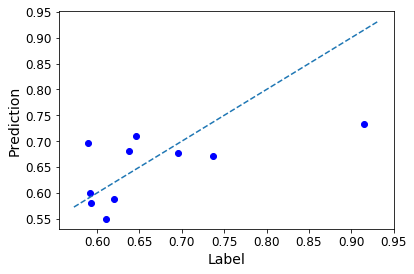

'TRAIN'


,Paclitaxel,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
5,0.189098,0.458177,0.510321,1.000000,1.000000,0.689968,0.237004,0.268781,0.248702,0.318648,...,0.344995,0.353347,0.656951,0.433871,0.552096,0.701703,0.565808,0.442113,1.000000,0.675145
61,1.000000,0.594291,0.098068,0.663465,0.595719,0.480350,0.124685,0.491681,0.560117,0.651548,...,0.727870,0.000000,0.407932,0.352019,0.248759,0.955732,0.924129,0.683940,0.474842,0.322228
38,0.476424,0.681447,0.414296,0.577636,0.556108,0.433226,0.346093,0.418220,0.479629,0.482155,...,0.558930,0.583485,0.618401,0.704551,0.601112,0.245613,0.062791,0.609377,0.655908,0.582340
8,0.631329,0.208752,0.446922,0.643878,0.633462,0.480553,0.505101,0.581324,0.628745,0.496464,...,0.649510,0.627223,0.892095,0.566748,0.716386,0.968147,0.891743,0.720827,0.308870,0.354462
56,0.309907,0.541005,0.413490,0.649224,0.626152,0.383829,0.789310,0.780155,0.954025,0.808523,...,0.614727,0.632708,0.796142,0.624753,0.789920,0.327401,0.104275,0.124598,0.429658,0.272249
28,0.459568,0.539843,0.421299,0.622050,0.068227,0.468144,0.493845,0.485450,0.560898,0.811290,...,0.571433,0.649558,0.360320,0.646695,0.733869,0.927926,0.906145,0.696618,0.031391,0.477550
25,0.323665,1.000000,0.402041,0.538924,0.498967,0.360709,0.316740,0.681776,0.875485,0.443234,...,0.502208,0.509994,0.715022,0.621832,0.616691,0.438227,0.207105,0.138614,0.608341,0.554931
41,0.232316,0.431420,0.373586,0.269970,0.545772,0.680533,0.484724,0.640273,0.727502,0.395463,...,0.638067,0.355703,0.621020,0.574220,0.643742,0.895410,0.866815,0.589863,0.139323,0.369032
60,0.251493,0.151704,0.330890,0.692339,0.698363,0.517362,0.416620,0.519930,0.609704,0.557072,...,0.626020,0.586060,0.843014,0.651297,0.709248,0.772063,0.686406,0.534985,0.452184,0.786874
76,0.563690,0.643920,0.414281,0.527215,0.510210,0.319807,0.332338,0.000000,0.435265,0.455187,...,0.522065,0.550841,0.695314,0.636239,0.669304,0.281695,0.000000,0.000000,0.345066,0.568518


'TEST'


,Paclitaxel,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
21,0.507224,0.541257,0.359750,0.569808,0.575752,0.069025,0.367233,0.633591,0.770165,0.701561,...,0.496680,0.223591,0.301237,0.350217,0.327414,0.883804,0.321941,0.308315,0.823457,0.400965
26,0.334253,0.178466,0.423717,0.526217,0.516867,0.138570,0.521577,0.593897,0.761437,0.656130,...,0.510857,0.116873,0.055166,0.361848,0.437110,0.544653,0.375847,0.255220,0.544012,0.377095
46,0.185797,0.491710,0.437571,0.631646,0.614919,0.863484,0.000000,0.490898,0.502975,0.490870,...,0.633267,0.243065,0.379824,0.085406,0.179824,0.834932,0.787422,0.691317,0.453179,0.229301
73,0.464685,0.144568,0.421202,0.621852,0.565820,0.792821,0.343404,0.426644,0.452852,0.480356,...,0.525516,0.543266,0.801305,0.759926,0.603681,0.797904,0.703240,0.643263,0.423652,0.528918
1,0.000000,0.618788,0.459500,0.547447,0.552445,0.355300,0.057703,0.422247,0.809767,0.322884,...,0.494364,0.330539,0.664642,0.418647,0.434409,0.680047,0.545906,0.429122,0.262497,0.460500
58,0.538679,0.568261,0.465238,0.306362,0.283276,0.581795,0.682312,0.507147,0.582341,0.502285,...,0.253847,0.646236,0.766507,0.692083,0.669390,0.960523,0.836287,0.690720,0.463914,0.419831
59,0.301274,0.145215,0.384339,0.603301,0.605577,0.390584,0.355022,0.449346,0.519111,0.489125,...,0.558018,0.610643,0.784404,0.553203,0.646987,0.341925,0.059352,0.962877,0.389448,0.567693
15,0.240419,0.534771,0.394177,0.560524,0.541142,0.424764,0.339763,0.440760,0.458882,0.485743,...,0.538202,0.529143,0.760456,0.606279,0.600099,0.845545,0.763891,0.619428,0.564165,0.266760
57,0.108591,0.654032,0.284559,0.106001,0.069314,0.425914,0.433926,0.609403,0.822013,0.559658,...,0.536156,0.189330,0.934612,0.725223,0.719887,0.566575,0.509288,0.730645,0.676997,0.314281
50,0.304598,0.315570,0.493621,0.282766,0.652270,0.484098,0.455033,0.370979,0.370050,0.604219,...,0.461069,0.487476,0.717166,0.453187,0.650282,1.000000,1.000000,0.804717,0.564712,0.037158


RMSE: 0.094588510667
Pearson: (0.36265959816185678, 0.30304500298031201)
Spearman: SpearmanrResult(correlation=0.13939393939393938, pvalue=0.70093188491005842)
[ 0.62381101  0.60243382  0.62750032  0.66529193  0.65984135  0.79883577
  0.59750024  0.6249266   0.6438947   0.69683339]


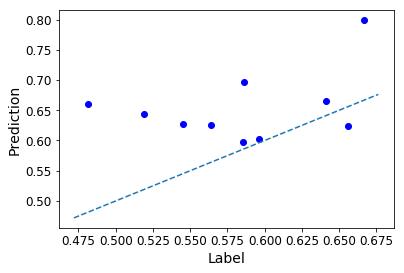

'TRAIN'


,SN-38,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
18,0.198785,0.444810,0.348151,0.461391,0.443357,0.039397,0.629698,0.612954,0.684137,0.386874,...,0.403267,0.420867,0.667315,0.585873,0.515893,0.744703,0.628185,0.498515,0.466320,0.623225
34,0.230900,0.657409,0.417028,0.770637,0.261215,0.591158,0.175526,0.712935,0.846873,0.512961,...,0.239650,0.626389,0.821501,0.539624,0.724915,0.598949,0.417160,0.616536,0.575513,0.611678
27,0.461784,0.571903,0.391065,0.080163,0.650224,0.900405,0.391290,0.511140,1.000000,0.477852,...,1.000000,0.011100,0.763857,0.584023,0.112634,0.892309,0.801685,0.586092,0.101403,0.269593
38,0.368571,0.681447,0.414296,0.577636,0.556108,0.433226,0.346093,0.418220,0.479629,0.482155,...,0.558930,0.583485,0.618401,0.704551,0.601112,0.245613,0.062791,0.609377,0.655908,0.582340
56,0.405654,0.541005,0.413490,0.649224,0.626152,0.383829,0.789310,0.780155,0.954025,0.808523,...,0.614727,0.632708,0.796142,0.624753,0.789920,0.327401,0.104275,0.124598,0.429658,0.272249
76,0.222786,0.643920,0.414281,0.527215,0.510210,0.319807,0.332338,0.000000,0.435265,0.455187,...,0.522065,0.550841,0.695314,0.636239,0.669304,0.281695,0.000000,0.000000,0.345066,0.568518
10,0.572325,0.634137,0.476524,0.700458,0.706705,0.498690,0.453072,0.351763,0.676323,0.510761,...,0.424049,0.635546,0.902508,0.642340,0.615439,0.425379,0.188977,0.155541,0.500573,0.318966
24,0.182784,0.666774,0.532750,0.501681,0.447857,0.758085,0.265007,0.897965,0.707626,0.635461,...,0.532536,0.092981,0.394541,0.096092,0.207210,0.752345,0.702895,0.126178,0.639310,1.000000
29,0.488432,0.480417,0.195828,0.424053,0.345974,0.427293,1.000000,0.585655,0.773364,0.541793,...,0.000000,0.623693,0.688855,0.654332,0.678819,0.741686,0.553022,0.861773,0.564321,0.582989
79,0.249202,0.468073,0.389849,0.615831,0.562937,0.844860,0.025393,0.677417,0.847127,0.509625,...,0.581937,0.576484,0.220781,0.746149,0.618465,0.790279,0.838705,0.604611,0.310993,0.579415


'TEST'


,SN-38,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
50,0.177895,0.315570,0.493621,0.282766,0.652270,0.484098,0.455033,0.370979,0.370050,0.604219,...,0.461069,0.487476,0.717166,0.453187,0.650282,1.000000,1.000000,0.804717,0.564712,0.037158
2,0.140614,0.570478,0.301675,0.491088,0.475242,0.049989,0.359572,0.378297,0.000000,0.366563,...,0.390156,0.468284,0.685681,0.508789,0.627497,0.528457,0.368854,0.259837,0.489809,0.638043
6,0.151476,0.055569,0.477054,0.419899,0.483759,0.542447,0.283704,0.429090,0.545555,0.590629,...,0.486347,0.301552,0.000000,0.000000,0.000000,0.964154,0.950729,0.696949,0.288636,0.329701
57,0.203416,0.654032,0.284559,0.106001,0.069314,0.425914,0.433926,0.609403,0.822013,0.559658,...,0.536156,0.189330,0.934612,0.725223,0.719887,0.566575,0.509288,0.730645,0.676997,0.314281
63,0.236873,0.000000,0.448256,0.505193,0.626299,0.491447,0.420612,0.473816,0.586161,0.535771,...,0.626427,0.675457,0.594658,0.650567,0.693478,0.966743,0.873038,0.692925,0.607528,0.317230
73,0.403226,0.144568,0.421202,0.621852,0.565820,0.792821,0.343404,0.426644,0.452852,0.480356,...,0.525516,0.543266,0.801305,0.759926,0.603681,0.797904,0.703240,0.643263,0.423652,0.528918
54,0.392528,0.513802,0.409158,0.590801,0.564857,0.436860,0.368585,0.435265,0.542094,0.501029,...,0.554738,0.637586,0.806440,0.648901,0.721877,0.933016,0.875391,0.645311,0.515546,0.380743
37,0.504722,0.648264,0.270311,0.386023,0.376413,0.732310,0.455922,0.491138,0.667986,0.528738,...,0.280214,0.566290,0.752493,0.568612,0.673637,0.724808,0.545226,1.000000,0.636577,0.142199
39,0.310817,0.407733,0.039614,0.646564,0.604881,0.420139,0.224013,0.600471,0.706380,0.483507,...,0.844728,0.599774,0.241896,0.799630,0.756343,0.628777,0.519688,0.838231,0.618148,0.465877
84,0.104427,0.500107,0.000000,0.070085,0.630115,0.350139,0.670178,0.636839,0.509391,0.354339,...,0.643978,0.562431,0.883640,0.542321,0.546038,0.846026,0.786491,0.700327,0.732414,0.263276


RMSE: 0.0598870233661
Pearson: (0.42827206975102083, 0.21690368318667533)
Spearman: SpearmanrResult(correlation=0.50303030303030294, pvalue=0.13833369839449197)
[ 0.66419276  0.51526823  0.54640296  0.6425893   0.65427269  0.61557543
  0.67099321  0.6171173   0.66773286  0.5878146 ]


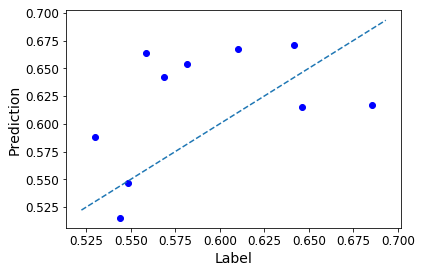

'TRAIN'


,5-FU,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
36,0.272459,0.546548,0.387784,0.583278,0.522926,0.818285,0.254720,0.380476,0.460696,0.456771,...,0.213084,0.522572,0.670966,0.605000,0.664904,0.851744,0.679045,0.818856,0.586175,0.271721
31,0.674490,0.500327,0.459422,0.654263,0.294883,0.657170,0.412499,0.749799,0.894843,0.529606,...,0.282816,0.645832,0.838487,0.811135,0.692139,0.957079,0.771404,0.623047,0.674199,0.607544
10,0.571010,0.634137,0.476524,0.700458,0.706705,0.498690,0.453072,0.351763,0.676323,0.510761,...,0.424049,0.635546,0.902508,0.642340,0.615439,0.425379,0.188977,0.155541,0.500573,0.318966
63,0.298573,0.000000,0.448256,0.505193,0.626299,0.491447,0.420612,0.473816,0.586161,0.535771,...,0.626427,0.675457,0.594658,0.650567,0.693478,0.966743,0.873038,0.692925,0.607528,0.317230
15,0.372023,0.534771,0.394177,0.560524,0.541142,0.424764,0.339763,0.440760,0.458882,0.485743,...,0.538202,0.529143,0.760456,0.606279,0.600099,0.845545,0.763891,0.619428,0.564165,0.266760
2,0.238265,0.570478,0.301675,0.491088,0.475242,0.049989,0.359572,0.378297,0.000000,0.366563,...,0.390156,0.468284,0.685681,0.508789,0.627497,0.528457,0.368854,0.259837,0.489809,0.638043
38,0.677725,0.681447,0.414296,0.577636,0.556108,0.433226,0.346093,0.418220,0.479629,0.482155,...,0.558930,0.583485,0.618401,0.704551,0.601112,0.245613,0.062791,0.609377,0.655908,0.582340
54,0.784789,0.513802,0.409158,0.590801,0.564857,0.436860,0.368585,0.435265,0.542094,0.501029,...,0.554738,0.637586,0.806440,0.648901,0.721877,0.933016,0.875391,0.645311,0.515546,0.380743
56,0.829909,0.541005,0.413490,0.649224,0.626152,0.383829,0.789310,0.780155,0.954025,0.808523,...,0.614727,0.632708,0.796142,0.624753,0.789920,0.327401,0.104275,0.124598,0.429658,0.272249
80,0.696700,0.505809,0.406499,0.596593,0.593182,0.402880,0.381676,1.000000,0.518664,0.743133,...,0.577359,0.591060,0.819576,0.613182,0.678784,0.373595,0.101834,0.653827,0.442354,0.534188


'TEST'


,5-FU,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
50,0.711173,0.315570,0.493621,0.282766,0.652270,0.484098,0.455033,0.370979,0.370050,0.604219,...,0.461069,0.487476,0.717166,0.453187,0.650282,1.000000,1.000000,0.804717,0.564712,0.037158
62,0.555231,0.406791,0.457535,0.707751,0.690998,0.262113,0.455094,0.619429,0.671450,0.338918,...,0.709678,0.355623,0.432747,0.628075,0.541996,0.665525,0.568335,0.417888,0.725006,0.535058
26,0.475809,0.178466,0.423717,0.526217,0.516867,0.138570,0.521577,0.593897,0.761437,0.656130,...,0.510857,0.116873,0.055166,0.361848,0.437110,0.544653,0.375847,0.255220,0.544012,0.377095
32,0.857367,0.670328,0.402479,0.630127,0.295637,0.630890,0.167236,0.739932,0.879926,0.504888,...,0.255797,0.637260,0.873212,0.684175,0.740348,0.562982,0.411478,0.641778,0.643763,0.618611
33,0.153952,0.642013,0.433032,0.649818,0.272455,0.528888,0.400068,0.725435,0.854246,0.358252,...,0.238406,0.614824,0.758995,0.736739,0.695500,0.852728,0.809026,0.651647,0.478803,0.614304
25,0.507988,1.000000,0.402041,0.538924,0.498967,0.360709,0.316740,0.681776,0.875485,0.443234,...,0.502208,0.509994,0.715022,0.621832,0.616691,0.438227,0.207105,0.138614,0.608341,0.554931
84,0.695757,0.500107,0.000000,0.070085,0.630115,0.350139,0.670178,0.636839,0.509391,0.354339,...,0.643978,0.562431,0.883640,0.542321,0.546038,0.846026,0.786491,0.700327,0.732414,0.263276
29,0.802109,0.480417,0.195828,0.424053,0.345974,0.427293,1.000000,0.585655,0.773364,0.541793,...,0.000000,0.623693,0.688855,0.654332,0.678819,0.741686,0.553022,0.861773,0.564321,0.582989
79,0.409901,0.468073,0.389849,0.615831,0.562937,0.844860,0.025393,0.677417,0.847127,0.509625,...,0.581937,0.576484,0.220781,0.746149,0.618465,0.790279,0.838705,0.604611,0.310993,0.579415


RMSE: 0.098742736542
Pearson: (-0.27060365968171946, 0.48127152459769484)
Spearman: SpearmanrResult(correlation=-0.25, pvalue=0.51648955230122628)
[ 0.82291521  0.81772797  0.78134236  0.74272909  0.75340837  0.82001385
  0.72806448  0.72838413  0.80389948]


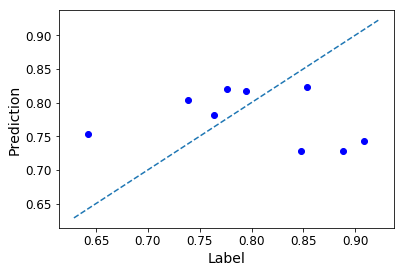

'TRAIN'


,Oxaliplatin,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
19,0.579714,0.618334,0.362236,0.584149,0.573832,0.039059,0.290241,0.569729,0.691886,0.358483,...,0.403782,0.072025,0.565873,0.223289,0.336184,0.880124,0.849009,0.347383,0.570548,0.429728
18,0.568196,0.444810,0.348151,0.461391,0.443357,0.039397,0.629698,0.612954,0.684137,0.386874,...,0.403267,0.420867,0.667315,0.585873,0.515893,0.744703,0.628185,0.498515,0.466320,0.623225
29,0.781331,0.480417,0.195828,0.424053,0.345974,0.427293,1.000000,0.585655,0.773364,0.541793,...,0.000000,0.623693,0.688855,0.654332,0.678819,0.741686,0.553022,0.861773,0.564321,0.582989
0,0.640947,0.586045,0.413890,0.581676,0.597584,0.403708,0.370938,0.777469,0.482592,0.449721,...,0.529853,0.588464,0.814575,0.667758,0.647601,0.293129,0.097432,0.062975,0.811752,0.583837
73,0.690664,0.144568,0.421202,0.621852,0.565820,0.792821,0.343404,0.426644,0.452852,0.480356,...,0.525516,0.543266,0.801305,0.759926,0.603681,0.797904,0.703240,0.643263,0.423652,0.528918
24,0.420011,0.666774,0.532750,0.501681,0.447857,0.758085,0.265007,0.897965,0.707626,0.635461,...,0.532536,0.092981,0.394541,0.096092,0.207210,0.752345,0.702895,0.126178,0.639310,1.000000
5,0.836824,0.458177,0.510321,1.000000,1.000000,0.689968,0.237004,0.268781,0.248702,0.318648,...,0.344995,0.353347,0.656951,0.433871,0.552096,0.701703,0.565808,0.442113,1.000000,0.675145
25,0.370150,1.000000,0.402041,0.538924,0.498967,0.360709,0.316740,0.681776,0.875485,0.443234,...,0.502208,0.509994,0.715022,0.621832,0.616691,0.438227,0.207105,0.138614,0.608341,0.554931
57,0.214547,0.654032,0.284559,0.106001,0.069314,0.425914,0.433926,0.609403,0.822013,0.559658,...,0.536156,0.189330,0.934612,0.725223,0.719887,0.566575,0.509288,0.730645,0.676997,0.314281
21,0.409144,0.541257,0.359750,0.569808,0.575752,0.069025,0.367233,0.633591,0.770165,0.701561,...,0.496680,0.223591,0.301237,0.350217,0.327414,0.883804,0.321941,0.308315,0.823457,0.400965


'TEST'


,Oxaliplatin,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
41,0.248494,0.431420,0.373586,0.269970,0.545772,0.680533,0.484724,0.640273,0.727502,0.395463,...,0.638067,0.355703,0.621020,0.574220,0.643742,0.895410,0.866815,0.589863,0.139323,0.369032
59,0.396023,0.145215,0.384339,0.603301,0.605577,0.390584,0.355022,0.449346,0.519111,0.489125,...,0.558018,0.610643,0.784404,0.553203,0.646987,0.341925,0.059352,0.962877,0.389448,0.567693
36,0.293446,0.546548,0.387784,0.583278,0.522926,0.818285,0.254720,0.380476,0.460696,0.456771,...,0.213084,0.522572,0.670966,0.605000,0.664904,0.851744,0.679045,0.818856,0.586175,0.271721
72,0.637337,0.510028,0.485671,0.665929,0.643821,0.004049,0.455140,0.295834,0.306934,0.424733,...,0.409391,0.489894,0.753597,0.456260,0.570648,0.711537,0.614654,0.470985,0.710750,0.293298
79,0.748083,0.468073,0.389849,0.615831,0.562937,0.844860,0.025393,0.677417,0.847127,0.509625,...,0.581937,0.576484,0.220781,0.746149,0.618465,0.790279,0.838705,0.604611,0.310993,0.579415
10,0.458401,0.634137,0.476524,0.700458,0.706705,0.498690,0.453072,0.351763,0.676323,0.510761,...,0.424049,0.635546,0.902508,0.642340,0.615439,0.425379,0.188977,0.155541,0.500573,0.318966
7,0.753741,0.293348,0.493562,0.717231,0.692684,0.000000,0.473357,0.557599,0.678752,0.384947,...,0.714344,0.431586,0.754759,0.541925,0.601298,0.745620,0.640065,0.528633,0.560425,0.000000
62,0.752160,0.406791,0.457535,0.707751,0.690998,0.262113,0.455094,0.619429,0.671450,0.338918,...,0.709678,0.355623,0.432747,0.628075,0.541996,0.665525,0.568335,0.417888,0.725006,0.535058
78,0.613169,0.531560,0.468257,0.722790,0.413626,0.613140,0.103190,0.578023,0.678843,0.529334,...,0.301920,0.685864,0.668148,0.696184,0.689366,0.448906,0.240819,0.199908,0.462320,0.340042


RMSE: 0.0847118921976
Pearson: (-0.24903317538025824, 0.51816675494688758)
Spearman: SpearmanrResult(correlation=-0.3666666666666667, pvalue=0.33173980143301507)
[ 0.88515626  0.82228804  0.84384554  0.79382345  0.87526444  0.8956748
  0.78458135  0.86444217  0.88977835]


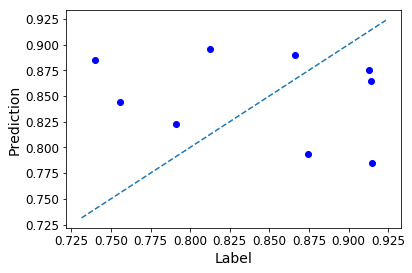

In [203]:
for label in labels:
    modelPipeline, labelPipeline, featureSetPipeline  = retrieve_pipelines("ridge_model", Ridge(alpha = 0.5), "normal")
    
    # Impute samples where label is NA
    X_nonNA, y_nonNA = remove_NAs(X, y, label)
    
    X_nonNA_tr = featureSetPipeline.fit_transform(X_nonNA)
    y_nonNA_tr = labelPipeline.fit_transform(y_nonNA)
    
    X_nonNA_tr = pd.DataFrame(data=X_nonNA_tr, index=X_nonNA.index.values, columns = X_nonNA.columns.values)
    y_nonNA_tr = pd.DataFrame(data=y_nonNA_tr, index=y_nonNA.index.values, columns = y_nonNA.columns.values)
    
    X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_nonNA_tr, y_nonNA_tr, test_size=0.15)
    
    
    display_set(X_TRAIN, X_TEST, Y_TRAIN, Y_TEST)

    y_test_np, y_prediction, this_y_train_tr = train_and_test(labelPipeline, XYpipeline, X_TRAIN, X_TEST, Y_TRAIN.values, Y_TEST.values)

    rmse, r, t = simple_score(y_test_np, y_prediction)
    
    print("RMSE: " + str(rmse))
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))

    #scores = cv_score(XYpipeline, X_TRAIN, this_y_train_tr)
    
    #print("CV Scores: " + str(scores))
    #print("CV Mean: " + str(scores.mean()))
    #print("CV STD: " + str(scores.std()))
    print(y_prediction)
    visualize(y_test_np, y_prediction)


### Visualize ML results using Random Forest Regressor

'TRAIN'


,Gemcitabine,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
84,0.183559,0.500107,0.000000,0.070085,0.630115,0.350139,0.670178,0.636839,0.509391,0.354339,...,0.643978,0.562431,0.883640,0.542321,0.546038,0.846026,0.786491,0.700327,0.732414,0.263276
75,0.072966,0.013914,0.449103,0.236002,0.236296,0.173376,0.490358,0.420508,0.485496,1.000000,...,0.822351,0.191414,0.676978,0.306209,0.381697,0.000000,0.706850,0.257868,0.402765,0.413218
28,0.669475,0.539843,0.421299,0.622050,0.068227,0.468144,0.493845,0.485450,0.560898,0.811290,...,0.571433,0.649558,0.360320,0.646695,0.733869,0.927926,0.906145,0.696618,0.031391,0.477550
25,0.423377,1.000000,0.402041,0.538924,0.498967,0.360709,0.316740,0.681776,0.875485,0.443234,...,0.502208,0.509994,0.715022,0.621832,0.616691,0.438227,0.207105,0.138614,0.608341,0.554931
58,0.510936,0.568261,0.465238,0.306362,0.283276,0.581795,0.682312,0.507147,0.582341,0.502285,...,0.253847,0.646236,0.766507,0.692083,0.669390,0.960523,0.836287,0.690720,0.463914,0.419831
39,0.177260,0.407733,0.039614,0.646564,0.604881,0.420139,0.224013,0.600471,0.706380,0.483507,...,0.844728,0.599774,0.241896,0.799630,0.756343,0.628777,0.519688,0.838231,0.618148,0.465877
42,0.320146,0.426146,0.366378,0.800673,0.794274,0.583916,0.283477,0.602809,0.756971,0.206466,...,0.559482,0.547543,0.283967,0.683587,0.578825,0.535504,0.336359,0.875892,0.547993,0.340315
17,0.256885,0.175859,0.436437,0.643136,0.636647,0.492062,0.696678,0.544771,0.444176,0.565450,...,0.629643,0.706401,0.745023,0.611213,0.653760,0.654363,0.570014,0.469477,0.310533,0.606470
62,0.270594,0.406791,0.457535,0.707751,0.690998,0.262113,0.455094,0.619429,0.671450,0.338918,...,0.709678,0.355623,0.432747,0.628075,0.541996,0.665525,0.568335,0.417888,0.725006,0.535058
78,0.651786,0.531560,0.468257,0.722790,0.413626,0.613140,0.103190,0.578023,0.678843,0.529334,...,0.301920,0.685864,0.668148,0.696184,0.689366,0.448906,0.240819,0.199908,0.462320,0.340042


'TEST'


,Gemcitabine,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
54,0.484657,0.513802,0.409158,0.590801,0.564857,0.436860,0.368585,0.435265,0.542094,0.501029,...,0.554738,0.637586,0.806440,0.648901,0.721877,0.933016,0.875391,0.645311,0.515546,0.380743
29,0.414519,0.480417,0.195828,0.424053,0.345974,0.427293,1.000000,0.585655,0.773364,0.541793,...,0.000000,0.623693,0.688855,0.654332,0.678819,0.741686,0.553022,0.861773,0.564321,0.582989
38,0.354739,0.681447,0.414296,0.577636,0.556108,0.433226,0.346093,0.418220,0.479629,0.482155,...,0.558930,0.583485,0.618401,0.704551,0.601112,0.245613,0.062791,0.609377,0.655908,0.582340
24,0.260888,0.666774,0.532750,0.501681,0.447857,0.758085,0.265007,0.897965,0.707626,0.635461,...,0.532536,0.092981,0.394541,0.096092,0.207210,0.752345,0.702895,0.126178,0.639310,1.000000
4,0.443248,0.499409,0.432776,0.594677,0.552785,0.389808,0.356806,0.450978,0.473759,0.476489,...,0.559761,1.000000,0.808121,1.000000,1.000000,0.860685,0.186620,0.637381,0.632049,0.244666
26,0.562618,0.178466,0.423717,0.526217,0.516867,0.138570,0.521577,0.593897,0.761437,0.656130,...,0.510857,0.116873,0.055166,0.361848,0.437110,0.544653,0.375847,0.255220,0.544012,0.377095
15,0.216886,0.534771,0.394177,0.560524,0.541142,0.424764,0.339763,0.440760,0.458882,0.485743,...,0.538202,0.529143,0.760456,0.606279,0.600099,0.845545,0.763891,0.619428,0.564165,0.266760
27,0.510019,0.571903,0.391065,0.080163,0.650224,0.900405,0.391290,0.511140,1.000000,0.477852,...,1.000000,0.011100,0.763857,0.584023,0.112634,0.892309,0.801685,0.586092,0.101403,0.269593
0,0.145345,0.586045,0.413890,0.581676,0.597584,0.403708,0.370938,0.777469,0.482592,0.449721,...,0.529853,0.588464,0.814575,0.667758,0.647601,0.293129,0.097432,0.062975,0.811752,0.583837
30,0.299586,0.378760,0.322814,0.400601,0.472073,0.481037,0.453107,0.463001,0.621711,0.401296,...,0.822903,0.426833,0.231060,0.429004,0.516456,0.731624,0.643351,0.505057,0.633888,0.329577


RMSE: 0.0784116277504
Pearson: (-0.30429025961141437, 0.3926493420718874)
Spearman: SpearmanrResult(correlation=-0.45454545454545447, pvalue=0.18690481034933201)
[ 0.70642797  0.65409267  0.72110338  0.76344699  0.71786674  0.6421352
  0.65453364  0.70485883  0.72626018  0.6710758 ]


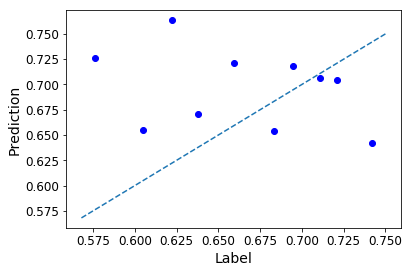

'TRAIN'


,Paclitaxel,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
3,0.481473,0.470856,0.538800,0.500594,0.532898,0.514990,0.430104,0.328675,0.412410,0.650823,...,0.742456,0.746243,0.951514,0.806488,0.867752,0.472066,0.280381,0.177838,0.631808,0.046523
30,0.498055,0.378760,0.322814,0.400601,0.472073,0.481037,0.453107,0.463001,0.621711,0.401296,...,0.822903,0.426833,0.231060,0.429004,0.516456,0.731624,0.643351,0.505057,0.633888,0.329577
34,0.385760,0.657409,0.417028,0.770637,0.261215,0.591158,0.175526,0.712935,0.846873,0.512961,...,0.239650,0.626389,0.821501,0.539624,0.724915,0.598949,0.417160,0.616536,0.575513,0.611678
24,0.231035,0.666774,0.532750,0.501681,0.447857,0.758085,0.265007,0.897965,0.707626,0.635461,...,0.532536,0.092981,0.394541,0.096092,0.207210,0.752345,0.702895,0.126178,0.639310,1.000000
10,0.650895,0.634137,0.476524,0.700458,0.706705,0.498690,0.453072,0.351763,0.676323,0.510761,...,0.424049,0.635546,0.902508,0.642340,0.615439,0.425379,0.188977,0.155541,0.500573,0.318966
78,0.766615,0.531560,0.468257,0.722790,0.413626,0.613140,0.103190,0.578023,0.678843,0.529334,...,0.301920,0.685864,0.668148,0.696184,0.689366,0.448906,0.240819,0.199908,0.462320,0.340042
56,0.309907,0.541005,0.413490,0.649224,0.626152,0.383829,0.789310,0.780155,0.954025,0.808523,...,0.614727,0.632708,0.796142,0.624753,0.789920,0.327401,0.104275,0.124598,0.429658,0.272249
21,0.507224,0.541257,0.359750,0.569808,0.575752,0.069025,0.367233,0.633591,0.770165,0.701561,...,0.496680,0.223591,0.301237,0.350217,0.327414,0.883804,0.321941,0.308315,0.823457,0.400965
80,0.243141,0.505809,0.406499,0.596593,0.593182,0.402880,0.381676,1.000000,0.518664,0.743133,...,0.577359,0.591060,0.819576,0.613182,0.678784,0.373595,0.101834,0.653827,0.442354,0.534188
6,0.248401,0.055569,0.477054,0.419899,0.483759,0.542447,0.283704,0.429090,0.545555,0.590629,...,0.486347,0.301552,0.000000,0.000000,0.000000,0.964154,0.950729,0.696949,0.288636,0.329701


'TEST'


,Paclitaxel,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
1,0.000000,0.618788,0.459500,0.547447,0.552445,0.355300,0.057703,0.422247,0.809767,0.322884,...,0.494364,0.330539,0.664642,0.418647,0.434409,0.680047,0.545906,0.429122,0.262497,0.460500
79,0.284271,0.468073,0.389849,0.615831,0.562937,0.844860,0.025393,0.677417,0.847127,0.509625,...,0.581937,0.576484,0.220781,0.746149,0.618465,0.790279,0.838705,0.604611,0.310993,0.579415
4,0.500377,0.499409,0.432776,0.594677,0.552785,0.389808,0.356806,0.450978,0.473759,0.476489,...,0.559761,1.000000,0.808121,1.000000,1.000000,0.860685,0.186620,0.637381,0.632049,0.244666
35,0.214000,0.599325,0.340716,0.495756,0.489493,0.504732,0.316781,0.762174,0.954758,0.409379,...,0.445907,0.477765,0.747443,0.631621,0.613046,0.490923,0.234680,0.975791,0.683867,0.343045
7,0.280438,0.293348,0.493562,0.717231,0.692684,0.000000,0.473357,0.557599,0.678752,0.384947,...,0.714344,0.431586,0.754759,0.541925,0.601298,0.745620,0.640065,0.528633,0.560425,0.000000
26,0.334253,0.178466,0.423717,0.526217,0.516867,0.138570,0.521577,0.593897,0.761437,0.656130,...,0.510857,0.116873,0.055166,0.361848,0.437110,0.544653,0.375847,0.255220,0.544012,0.377095
61,1.000000,0.594291,0.098068,0.663465,0.595719,0.480350,0.124685,0.491681,0.560117,0.651548,...,0.727870,0.000000,0.407932,0.352019,0.248759,0.955732,0.924129,0.683940,0.474842,0.322228
17,0.442873,0.175859,0.436437,0.643136,0.636647,0.492062,0.696678,0.544771,0.444176,0.565450,...,0.629643,0.706401,0.745023,0.611213,0.653760,0.654363,0.570014,0.469477,0.310533,0.606470
45,0.579476,0.575609,0.422320,0.605210,0.611930,0.393298,0.338614,0.470841,0.520370,0.528418,...,0.591165,0.627879,0.846944,0.748739,0.768954,0.355233,0.074998,0.705517,0.435695,0.325351
71,0.700754,0.449288,0.150426,0.551095,0.510634,0.105600,0.295615,0.577331,0.720465,0.768171,...,0.478059,0.829160,0.430884,0.792287,0.828743,0.806869,0.747397,0.586592,0.554940,0.392041


RMSE: 0.0941327061616
Pearson: (0.06854515077808869, 0.85075999445302142)
Spearman: SpearmanrResult(correlation=-0.22424242424242422, pvalue=0.53340056127259472)
[ 0.64337578  0.57127341  0.68795901  0.6326182   0.63556024  0.61648823
  0.63090159  0.60978648  0.62859504  0.62314129]


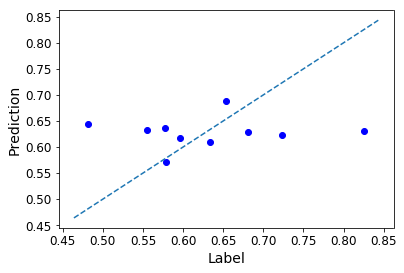

'TRAIN'


,SN-38,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
53,0.242613,0.301916,0.401777,0.325917,0.392521,0.613203,0.166246,0.512423,0.536952,0.247395,...,0.614826,0.202286,0.488277,0.356958,0.290095,0.543626,0.353593,0.348107,0.754920,0.389584
7,0.314419,0.293348,0.493562,0.717231,0.692684,0.000000,0.473357,0.557599,0.678752,0.384947,...,0.714344,0.431586,0.754759,0.541925,0.601298,0.745620,0.640065,0.528633,0.560425,0.000000
32,0.300558,0.670328,0.402479,0.630127,0.295637,0.630890,0.167236,0.739932,0.879926,0.504888,...,0.255797,0.637260,0.873212,0.684175,0.740348,0.562982,0.411478,0.641778,0.643763,0.618611
22,1.000000,0.947023,0.153753,0.493134,0.478187,1.000000,0.436856,0.357752,0.379331,0.781517,...,0.459640,0.262440,1.000000,0.839109,0.786992,0.775968,0.231369,0.555888,0.368169,0.338869
62,0.152914,0.406791,0.457535,0.707751,0.690998,0.262113,0.455094,0.619429,0.671450,0.338918,...,0.709678,0.355623,0.432747,0.628075,0.541996,0.665525,0.568335,0.417888,0.725006,0.535058
58,0.290375,0.568261,0.465238,0.306362,0.283276,0.581795,0.682312,0.507147,0.582341,0.502285,...,0.253847,0.646236,0.766507,0.692083,0.669390,0.960523,0.836287,0.690720,0.463914,0.419831
14,0.153958,0.538768,0.450830,0.000000,0.000000,0.899807,0.369437,0.447762,0.484931,0.496228,...,0.553908,0.579830,0.799303,0.746681,0.617332,0.893803,0.810621,0.635395,0.364281,0.583968
30,0.488965,0.378760,0.322814,0.400601,0.472073,0.481037,0.453107,0.463001,0.621711,0.401296,...,0.822903,0.426833,0.231060,0.429004,0.516456,0.731624,0.643351,0.505057,0.633888,0.329577
38,0.368571,0.681447,0.414296,0.577636,0.556108,0.433226,0.346093,0.418220,0.479629,0.482155,...,0.558930,0.583485,0.618401,0.704551,0.601112,0.245613,0.062791,0.609377,0.655908,0.582340
44,0.193371,0.561890,0.313766,0.641870,0.593902,0.470134,0.202295,0.267489,0.172740,0.492099,...,0.339114,0.059105,0.376569,0.108576,0.165925,0.608814,0.537615,0.521244,0.000000,0.566378


'TEST'


,SN-38,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
25,0.230449,1.000000,0.402041,0.538924,0.498967,0.360709,0.316740,0.681776,0.875485,0.443234,...,0.502208,0.509994,0.715022,0.621832,0.616691,0.438227,0.207105,0.138614,0.608341,0.554931
76,0.222786,0.643920,0.414281,0.527215,0.510210,0.319807,0.332338,0.000000,0.435265,0.455187,...,0.522065,0.550841,0.695314,0.636239,0.669304,0.281695,0.000000,0.000000,0.345066,0.568518
79,0.249202,0.468073,0.389849,0.615831,0.562937,0.844860,0.025393,0.677417,0.847127,0.509625,...,0.581937,0.576484,0.220781,0.746149,0.618465,0.790279,0.838705,0.604611,0.310993,0.579415
26,0.428060,0.178466,0.423717,0.526217,0.516867,0.138570,0.521577,0.593897,0.761437,0.656130,...,0.510857,0.116873,0.055166,0.361848,0.437110,0.544653,0.375847,0.255220,0.544012,0.377095
75,0.122341,0.013914,0.449103,0.236002,0.236296,0.173376,0.490358,0.420508,0.485496,1.000000,...,0.822351,0.191414,0.676978,0.306209,0.381697,0.000000,0.706850,0.257868,0.402765,0.413218
8,0.775984,0.208752,0.446922,0.643878,0.633462,0.480553,0.505101,0.581324,0.628745,0.496464,...,0.649510,0.627223,0.892095,0.566748,0.716386,0.968147,0.891743,0.720827,0.308870,0.354462
78,0.544914,0.531560,0.468257,0.722790,0.413626,0.613140,0.103190,0.578023,0.678843,0.529334,...,0.301920,0.685864,0.668148,0.696184,0.689366,0.448906,0.240819,0.199908,0.462320,0.340042
15,0.181762,0.534771,0.394177,0.560524,0.541142,0.424764,0.339763,0.440760,0.458882,0.485743,...,0.538202,0.529143,0.760456,0.606279,0.600099,0.845545,0.763891,0.619428,0.564165,0.266760
39,0.310817,0.407733,0.039614,0.646564,0.604881,0.420139,0.224013,0.600471,0.706380,0.483507,...,0.844728,0.599774,0.241896,0.799630,0.756343,0.628777,0.519688,0.838231,0.618148,0.465877
42,0.497566,0.426146,0.366378,0.800673,0.794274,0.583916,0.283477,0.602809,0.756971,0.206466,...,0.559482,0.547543,0.283967,0.683587,0.578825,0.535504,0.336359,0.875892,0.547993,0.340315


RMSE: 0.0750642588216
Pearson: (0.24498338691288862, 0.4951202990728239)
Spearman: SpearmanrResult(correlation=0.33333333333333326, pvalue=0.34659350708733405)
[ 0.59843588  0.6274658   0.58567281  0.60699721  0.55356994  0.59133762
  0.64415879  0.61583523  0.65030706  0.6285754 ]


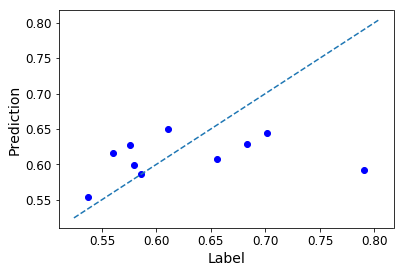

'TRAIN'


,5-FU,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
18,0.380507,0.444810,0.348151,0.461391,0.443357,0.039397,0.629698,0.612954,0.684137,0.386874,...,0.403267,0.420867,0.667315,0.585873,0.515893,0.744703,0.628185,0.498515,0.466320,0.623225
22,1.000000,0.947023,0.153753,0.493134,0.478187,1.000000,0.436856,0.357752,0.379331,0.781517,...,0.459640,0.262440,1.000000,0.839109,0.786992,0.775968,0.231369,0.555888,0.368169,0.338869
78,0.897761,0.531560,0.468257,0.722790,0.413626,0.613140,0.103190,0.578023,0.678843,0.529334,...,0.301920,0.685864,0.668148,0.696184,0.689366,0.448906,0.240819,0.199908,0.462320,0.340042
60,0.470851,0.151704,0.330890,0.692339,0.698363,0.517362,0.416620,0.519930,0.609704,0.557072,...,0.626020,0.586060,0.843014,0.651297,0.709248,0.772063,0.686406,0.534985,0.452184,0.786874
3,0.641052,0.470856,0.538800,0.500594,0.532898,0.514990,0.430104,0.328675,0.412410,0.650823,...,0.742456,0.746243,0.951514,0.806488,0.867752,0.472066,0.280381,0.177838,0.631808,0.046523
21,0.451241,0.541257,0.359750,0.569808,0.575752,0.069025,0.367233,0.633591,0.770165,0.701561,...,0.496680,0.223591,0.301237,0.350217,0.327414,0.883804,0.321941,0.308315,0.823457,0.400965
63,0.298573,0.000000,0.448256,0.505193,0.626299,0.491447,0.420612,0.473816,0.586161,0.535771,...,0.626427,0.675457,0.594658,0.650567,0.693478,0.966743,0.873038,0.692925,0.607528,0.317230
39,0.286578,0.407733,0.039614,0.646564,0.604881,0.420139,0.224013,0.600471,0.706380,0.483507,...,0.844728,0.599774,0.241896,0.799630,0.756343,0.628777,0.519688,0.838231,0.618148,0.465877
29,0.802109,0.480417,0.195828,0.424053,0.345974,0.427293,1.000000,0.585655,0.773364,0.541793,...,0.000000,0.623693,0.688855,0.654332,0.678819,0.741686,0.553022,0.861773,0.564321,0.582989
76,0.512729,0.643920,0.414281,0.527215,0.510210,0.319807,0.332338,0.000000,0.435265,0.455187,...,0.522065,0.550841,0.695314,0.636239,0.669304,0.281695,0.000000,0.000000,0.345066,0.568518


'TEST'


,5-FU,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
57,0.158746,0.654032,0.284559,0.106001,0.069314,0.425914,0.433926,0.609403,0.822013,0.559658,...,0.536156,0.189330,0.934612,0.725223,0.719887,0.566575,0.509288,0.730645,0.676997,0.314281
75,0.084643,0.013914,0.449103,0.236002,0.236296,0.173376,0.490358,0.420508,0.485496,1.000000,...,0.822351,0.191414,0.676978,0.306209,0.381697,0.000000,0.706850,0.257868,0.402765,0.413218
38,0.677725,0.681447,0.414296,0.577636,0.556108,0.433226,0.346093,0.418220,0.479629,0.482155,...,0.558930,0.583485,0.618401,0.704551,0.601112,0.245613,0.062791,0.609377,0.655908,0.582340
0,0.492082,0.586045,0.413890,0.581676,0.597584,0.403708,0.370938,0.777469,0.482592,0.449721,...,0.529853,0.588464,0.814575,0.667758,0.647601,0.293129,0.097432,0.062975,0.811752,0.583837
56,0.829909,0.541005,0.413490,0.649224,0.626152,0.383829,0.789310,0.780155,0.954025,0.808523,...,0.614727,0.632708,0.796142,0.624753,0.789920,0.327401,0.104275,0.124598,0.429658,0.272249
45,0.987596,0.575609,0.422320,0.605210,0.611930,0.393298,0.338614,0.470841,0.520370,0.528418,...,0.591165,0.627879,0.846944,0.748739,0.768954,0.355233,0.074998,0.705517,0.435695,0.325351
30,0.629550,0.378760,0.322814,0.400601,0.472073,0.481037,0.453107,0.463001,0.621711,0.401296,...,0.822903,0.426833,0.231060,0.429004,0.516456,0.731624,0.643351,0.505057,0.633888,0.329577
5,0.368260,0.458177,0.510321,1.000000,1.000000,0.689968,0.237004,0.268781,0.248702,0.318648,...,0.344995,0.353347,0.656951,0.433871,0.552096,0.701703,0.565808,0.442113,1.000000,0.675145
28,0.796775,0.539843,0.421299,0.622050,0.068227,0.468144,0.493845,0.485450,0.560898,0.811290,...,0.571433,0.649558,0.360320,0.646695,0.733869,0.927926,0.906145,0.696618,0.031391,0.477550


RMSE: 0.0966158118263
Pearson: (0.48273399075236928, 0.18809825845633835)
Spearman: SpearmanrResult(correlation=0.48333333333333334, pvalue=0.18746985521554207)
[ 0.82257147  0.67960386  0.85389535  0.81884828  0.84624496  0.75704478
  0.8197859   0.74051684  0.84350664]


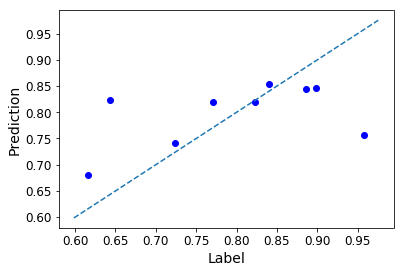

'TRAIN'


,Oxaliplatin,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
19,0.579714,0.618334,0.362236,0.584149,0.573832,0.039059,0.290241,0.569729,0.691886,0.358483,...,0.403782,0.072025,0.565873,0.223289,0.336184,0.880124,0.849009,0.347383,0.570548,0.429728
41,0.248494,0.431420,0.373586,0.269970,0.545772,0.680533,0.484724,0.640273,0.727502,0.395463,...,0.638067,0.355703,0.621020,0.574220,0.643742,0.895410,0.866815,0.589863,0.139323,0.369032
58,0.699501,0.568261,0.465238,0.306362,0.283276,0.581795,0.682312,0.507147,0.582341,0.502285,...,0.253847,0.646236,0.766507,0.692083,0.669390,0.960523,0.836287,0.690720,0.463914,0.419831
35,0.413885,0.599325,0.340716,0.495756,0.489493,0.504732,0.316781,0.762174,0.954758,0.409379,...,0.445907,0.477765,0.747443,0.631621,0.613046,0.490923,0.234680,0.975791,0.683867,0.343045
37,0.592040,0.648264,0.270311,0.386023,0.376413,0.732310,0.455922,0.491138,0.667986,0.528738,...,0.280214,0.566290,0.752493,0.568612,0.673637,0.724808,0.545226,1.000000,0.636577,0.142199
40,0.601912,0.168212,0.359513,0.531764,0.548020,0.431386,0.360306,0.580564,0.661154,0.480426,...,0.577572,0.593755,0.664700,0.656005,0.646501,0.342142,0.029604,0.029294,0.432383,0.413730
71,0.767337,0.449288,0.150426,0.551095,0.510634,0.105600,0.295615,0.577331,0.720465,0.768171,...,0.478059,0.829160,0.430884,0.792287,0.828743,0.806869,0.747397,0.586592,0.554940,0.392041
16,0.744436,0.200616,0.441145,0.771983,0.734286,0.370422,0.371997,0.506582,0.331596,0.000000,...,0.573528,0.617453,0.868775,0.664620,0.743083,0.337943,0.095817,0.158339,0.404660,0.264194
15,0.639711,0.534771,0.394177,0.560524,0.541142,0.424764,0.339763,0.440760,0.458882,0.485743,...,0.538202,0.529143,0.760456,0.606279,0.600099,0.845545,0.763891,0.619428,0.564165,0.266760
50,0.552800,0.315570,0.493621,0.282766,0.652270,0.484098,0.455033,0.370979,0.370050,0.604219,...,0.461069,0.487476,0.717166,0.453187,0.650282,1.000000,1.000000,0.804717,0.564712,0.037158


'TEST'


,Oxaliplatin,1,3,8,9,16,18,22,23,24,...,65,67,68,69,70,72,73,74,77,80
23,0.000000,0.613607,0.482529,0.739527,0.714742,0.122209,0.504176,0.439934,0.381619,0.442549,...,0.110568,0.632151,0.807767,0.599939,0.696111,0.458270,0.251931,0.587867,0.360722,0.334334
0,0.640947,0.586045,0.413890,0.581676,0.597584,0.403708,0.370938,0.777469,0.482592,0.449721,...,0.529853,0.588464,0.814575,0.667758,0.647601,0.293129,0.097432,0.062975,0.811752,0.583837
78,0.613169,0.531560,0.468257,0.722790,0.413626,0.613140,0.103190,0.578023,0.678843,0.529334,...,0.301920,0.685864,0.668148,0.696184,0.689366,0.448906,0.240819,0.199908,0.462320,0.340042
31,0.636971,0.500327,0.459422,0.654263,0.294883,0.657170,0.412499,0.749799,0.894843,0.529606,...,0.282816,0.645832,0.838487,0.811135,0.692139,0.957079,0.771404,0.623047,0.674199,0.607544
22,1.000000,0.947023,0.153753,0.493134,0.478187,1.000000,0.436856,0.357752,0.379331,0.781517,...,0.459640,0.262440,1.000000,0.839109,0.786992,0.775968,0.231369,0.555888,0.368169,0.338869
32,0.824374,0.670328,0.402479,0.630127,0.295637,0.630890,0.167236,0.739932,0.879926,0.504888,...,0.255797,0.637260,0.873212,0.684175,0.740348,0.562982,0.411478,0.641778,0.643763,0.618611
27,0.463957,0.571903,0.391065,0.080163,0.650224,0.900405,0.391290,0.511140,1.000000,0.477852,...,1.000000,0.011100,0.763857,0.584023,0.112634,0.892309,0.801685,0.586092,0.101403,0.269593
57,0.214547,0.654032,0.284559,0.106001,0.069314,0.425914,0.433926,0.609403,0.822013,0.559658,...,0.536156,0.189330,0.934612,0.725223,0.719887,0.566575,0.509288,0.730645,0.676997,0.314281
21,0.409144,0.541257,0.359750,0.569808,0.575752,0.069025,0.367233,0.633591,0.770165,0.701561,...,0.496680,0.223591,0.301237,0.350217,0.327414,0.883804,0.321941,0.308315,0.823457,0.400965


RMSE: 0.103169450833
Pearson: (0.094745062928122778, 0.80842495512619161)
Spearman: SpearmanrResult(correlation=0.016666666666666666, pvalue=0.96605480399468613)
[ 0.84383598  0.82345719  0.8642147   0.90926401  0.84215284  0.85063747
  0.77871699  0.82840061  0.90454026]


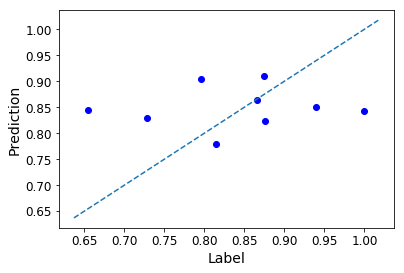

In [204]:
for label in labels:
    modelPipeline, labelPipeline, featureSetPipeline  = retrieve_pipelines("rfs_model", RandomForestRegressor(n_estimators=500, max_leaf_nodes=16, n_jobs=8), "normal")
    
    # Impute samples where label is NA
    X_nonNA, y_nonNA = remove_NAs(X, y, label)
    
    X_nonNA_tr = featureSetPipeline.fit_transform(X_nonNA)
    y_nonNA_tr = labelPipeline.fit_transform(y_nonNA)
    
    X_nonNA_tr = pd.DataFrame(data=X_nonNA_tr, index=X_nonNA.index.values, columns = X_nonNA.columns.values)
    y_nonNA_tr = pd.DataFrame(data=y_nonNA_tr, index=y_nonNA.index.values, columns = y_nonNA.columns.values)
    
    X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_nonNA_tr, y_nonNA_tr, test_size=0.15)
    
    
    display_set(X_TRAIN, X_TEST, Y_TRAIN, Y_TEST)

    y_test_np, y_prediction, this_y_train_tr = train_and_test(labelPipeline, XYpipeline, X_TRAIN, X_TEST, Y_TRAIN.values, Y_TEST.values)

    rmse, r, t = simple_score(y_test_np, y_prediction)
    
    print("RMSE: " + str(rmse))
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))

    #scores = cv_score(XYpipeline, X_TRAIN, this_y_train_tr)
    
    #print("CV Scores: " + str(scores))
    #print("CV Mean: " + str(scores.mean()))
    #print("CV STD: " + str(scores.std()))
    print(y_prediction)
    visualize(y_test_np, y_prediction)


### Bootstrap Regression Model

RMSE: 0.0888520105669
Pearson: (0.30258336170477418, 0.015935643612153261)
Spearman: SpearmanrResult(correlation=0.21382184077552904, pvalue=0.092434177708721393)


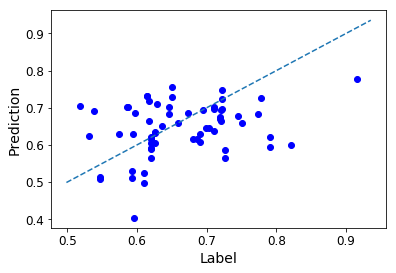

RMSE: 0.0856807726821
Pearson: (0.17226334532057744, 0.1770048546601522)
Spearman: SpearmanrResult(correlation=0.13966166880078895, pvalue=0.274968135579924)


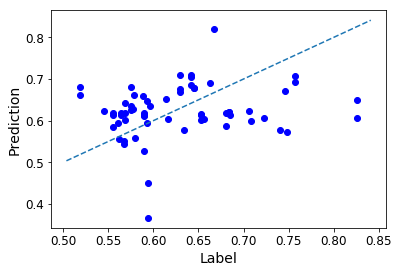

RMSE: 0.0983211439878
Pearson: (-0.15410597684957142, 0.22785471785655889)
Spearman: SpearmanrResult(correlation=-0.14115361594923423, pvalue=0.26982198410435371)


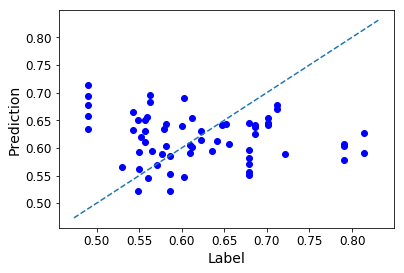

RMSE: 0.0996197383583
Pearson: (0.1171956115769623, 0.39868567136940114)
Spearman: SpearmanrResult(correlation=0.18041415914883133, pvalue=0.19172645338087749)


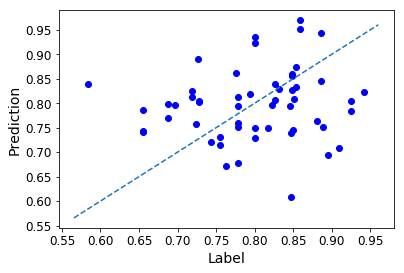

RMSE: 0.102683046824
Pearson: (-0.23076295869725777, 0.093187373043928323)
Spearman: SpearmanrResult(correlation=-0.26119465403804393, pvalue=0.056425884303027009)


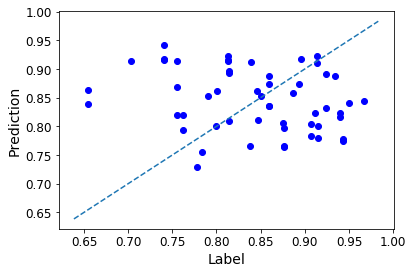

In [133]:
for label in labels:
    X_nonNA, y_nonNA = remove_NAs(X, y, label)
    
    all_y_test_np = np.array([])
    all_y_prediction = np.array([])
    for i in range(1,10):
        X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_nonNA, y_nonNA, test_size=0.10)

        Ypipeline, XYpipeline = retrieve_pipelines("ridge_model", Ridge(alpha = 0.50))

        y_test_np, y_prediction, _ = train_and_test(Ypipeline, XYpipeline, X_TRAIN, X_TEST, Y_TRAIN.values, Y_TEST.values)
        all_y_test_np = np.append(all_y_test_np, y_test_np)
        all_y_prediction = np.append(all_y_prediction, y_prediction)
        
    rmse, r, t = simple_score(all_y_test_np, all_y_prediction)
    
    print("RMSE: " + str(rmse))
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))
    visualize(all_y_test_np, all_y_prediction)


### Bootstrap Random Forest Model

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.0711386310753
Pearson: (0.040834599131047145, 0.75066944258546786)
Spearman: SpearmanrResult(correlation=0.013880219025600857, pvalue=0.91401963396027708)


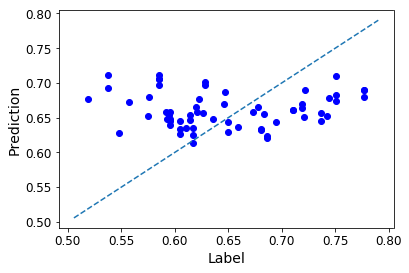

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.0739350736649
Pearson: (-0.23759096381020947, 0.060792367957492835)
Spearman: SpearmanrResult(correlation=-0.23424052128434777, pvalue=0.064632053873727918)


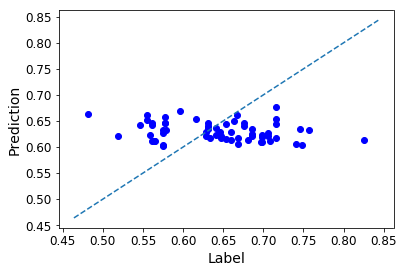

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.0719370092654
Pearson: (0.07282283037777533, 0.57058337468394549)
Spearman: SpearmanrResult(correlation=0.12200249655077749, pvalue=0.34082426941957478)


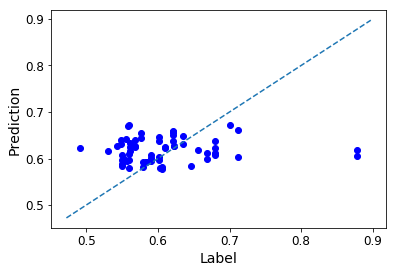

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.0910053559737
Pearson: (-0.014857724090135508, 0.91508042660663702)
Spearman: SpearmanrResult(correlation=-0.0018684106390683697, pvalue=0.98930172874597067)


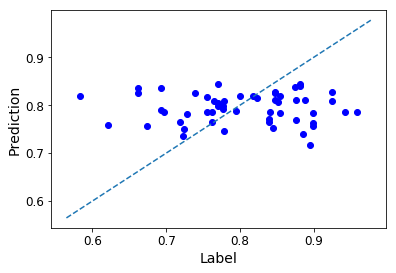

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.0883163059969
Pearson: (-0.28661689327777146, 0.035621802193783837)
Spearman: SpearmanrResult(correlation=-0.27144630789296198, pvalue=0.047089664310731201)


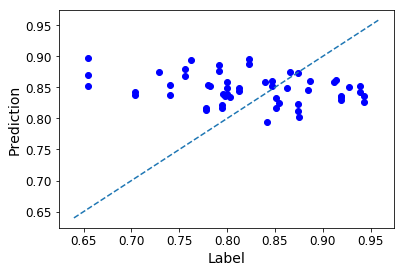

In [40]:
for label in labels:
    X_nonNA, y_nonNA = remove_NAs(X, y, label)
    
    all_y_test_np = np.array([])
    all_y_prediction = np.array([])
    for i in range(1,10):
        X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_nonNA, y_nonNA, test_size=0.10)

        Ypipeline, XYpipeline = retrieve_pipelines("rfs_model", RandomForestRegressor(n_estimators=1000, max_leaf_nodes=8, n_jobs=4))

        y_test_np, y_prediction, _ = train_and_test(Ypipeline, XYpipeline, X_TRAIN, X_TEST, Y_TRAIN.values, Y_TEST.values)
        all_y_test_np = np.append(all_y_test_np, y_test_np)
        all_y_prediction = np.append(all_y_prediction, y_prediction)
        
    rmse, r, t = simple_score(all_y_test_np, all_y_prediction)
    
    print("RMSE: " + str(rmse))
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))
    visualize(all_y_test_np, all_y_prediction)
